In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.svm import SVC
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed

In [2]:
# Return the explained variance score given some test data. 
def my_score(clf, X_test, y_test):
    y_predict = clf.predict(X_test)
    return explained_variance_score(y_test, y_predict)

# Return multiple scores and plot predicted vs. true. 
def classifier_analysis(clf, X_test, y_test):
    y_predict = clf.predict(X_test)
    mse_ = mean_squared_error(y_test, y_predict)
    evs_ = explained_variance_score(y_test, y_predict)
    
    print('Mean squared error {:0.5f}'.format(mse_))
    print('Explained variance score {:0.5f}'.format(evs_))
    
    fig = plt.figure()
    plt.scatter(y_test, y_predict, s=1)
    plt.plot([0,1],[0,1],color='r')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    plt.grid()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    _ = plt.show()
    return explained_variance_score(y_test, y_predict)

In [3]:
# Convert date-like + 'Missing' valued features to one-hot encoded columns; uses KBins on the years of the date-like, which 
# bins then one-hot encodes, while also one-hot encoding 'Missing' separately. 
def encode_dates_and_missing(df):
    for i, seriesname in enumerate(df.columns):
        series = df[seriesname]
        series_missing = pd.get_dummies(series[series=='Missing'])
        series_notmissing = series[series!='Missing']
        notmiss_index =series_notmissing.index
        
        kbd = KBinsDiscretizer(n_bins=3, strategy='uniform')
        series_dt = pd.to_datetime(series_notmissing).dt.year
        encoded_series = kbd.fit_transform(series_dt.values.reshape(-1,1))
        encoded_series = pd.DataFrame(kbd.fit_transform(series_dt.values.reshape(-1,1)).toarray(),index=notmiss_index).astype(int)
        encoded_series = encoded_series.join(series_missing, how='outer').fillna(value=0)
        encoded_series.columns = [seriesname+'_'+str(col) for col in encoded_series.columns]
        
        if i == 0: 
            encoded_df = encoded_series
        else:
            encoded_df = pd.concat((encoded_df,encoded_series),axis=1)
            
    return encoded_df
    

### 1. Reformulate the hypothesis

The original idea of this stage of the project was to create a predictive model for the amount of money recovered from a charged off loan. The problem with this is that there is no indication, however, as to the total outstanding amount of money *currently* owed. Unfortunately the outstanding principal isn't recorded because once a loan is charged off, there is technically no outstanding principal. 

This is a problem as the model was supposed to predict the amount of money that ***could*** be recovered from each charged off loan. If the model predicts amounts that are greater than the total possible amount, then it isn't a very useful model. Therefore, when producing the model, it either has to be interpreted only as a rough estimate, or something else needs to be done to ensure that the predicted variable always has a sensible interpretation. The latter is obviously a better choice and as such that is what is pursued here.

The hypothesis needs to be modified; changing from

    *How much money from charged off loans will be recovered?*
    
To:

    *What percentage of the principal still owed will be recovered?"


### 2. Construction of a new target variable.
To accomodate this fact, we calculate the outstanding principal that could be recovered from charged off loans by subtraction of the total received principal from the loan amount. This model disregards financial constructions like interest and late fees. This is done for multiple reasons

    1. There is no indication as to how much capital is owed in the form of late fees and interest
    2. There is no upper bound on the amount of interest and late fees that could be owed
    3. The late fees and interest accrue over time. 
    2. The model should incorporate as much data in the modeling process as possible
    3. The principal is actually funded by the company or investors; it contributes to actual loss

In the construction of the new target variable, it is beneficial to involve as little data as possible (such as interest and late fee data), as it won't be able to be used to train the model. Therefore, the target variable we construct is the ratio of the net recovered amount to the outstanding principal.
Originally thought of doing loan amount - total payments, but total payments includes interest and late fees so this quantity can be negative and hence nonsensical. The equation for the new target variable is then

<h3 align="center">
$ \text{Percentage recovered} = \: \frac{\text{Recovery amount} - \text{Collection Fees}}{\text{Loan amount}-\text{Principal amount received}}$
</h3> 

It turns out what was written above is terrible.

The modeling in this notebook is regression of a continuous variable. There are many categorical type variables which
need to be encoded in order to be used for regression. There are a number of categorical variables with a large (100+) number of categories. There is 

In [4]:
loan_data = pd.read_csv('regression_loan_data.csv',index_col=False)

#Still contains missing values; first, drop features with missing values (dropping samples leaves us with no data).
loan_data = loan_data.dropna(axis=1)

There are twenty loans whose principal amount has been paid off; remove these from the dataset.

In [5]:
# regression_data = loan_data[(loan_data.loan_amnt-loan_data.total_rec_prncp)>0]
# net_recovery = regression_data.recoveries  - regression_data.collection_recovery_fee
# remaining_principal = regression_data.loan_amnt  - regression_data.total_rec_prncp

# regression_data = loan_data[(loan_data.loan_amnt-loan_data.total_rec_prncp)>0]
# net_recovery = regression_data.recoveries  - regression_data.collection_recovery_fee
# remaining_principal = regression_data.loan_amnt  - regression_data.total_rec_prncp

# remaining_principal = remaining_principal[remaining_principal > 0]
# net_recovery = net_recovery[remaining_principal.index]
# target = net_recovery / (remaining_principal)

# target = target[target < 1]
# regression_data = regression_data.loc[target.index, :]

# Assign target/training variables
# y = target
# X = regression_data.loc[y.index,:]
# X = regression_data.drop(columns=['recoveries']).loc[y.index,:]
# X = regression_data.drop(columns=['recoveries','loan_amnt','collection_recovery_fee','total_rec_prncp']).loc[y.index,:]

Target variables greater than one at this point indicate that most of the recoveries were made on interest and late fees and as such shouldn't be used to create our model. 

Our prediction is occuring in the present moment. All of the data corresponding to charged-off loans can be used, and it does not have to be treated as a time series, as we are not trying to predict the future.

The modeling in this notebook is regression of a continuous variable. There are many categorical type variables which
need to be encoded (transformed to numerical values) in order to be used for regression. A portion of these variables have a large (100+) number of categories.

In [6]:
loan_data.select_dtypes(include='object').nunique().sort_values(ascending=False).head(10)

zip_code                     900
earliest_cr_line             686
sec_app_earliest_cr_line     451
issue_d                      137
last_pymnt_d                 132
last_credit_pull_d           114
settlement_date               89
debt_settlement_flag_date     83
addr_state                    51
sub_grade                     35
dtype: int64

The largest number of categories belongs to the zip code variable; which is reported as the first three digits (followed by 'xx'). We can reduce the number of categories by aggregating by the first *two* digits; but if we do this it is almost nearly
the same as identifying by the state; In fact, roudning to two digits is actually less specific than identifying by the state. We already have the state in 'addr_state' feature data so there is no motivation to keep the zip codes; if we're going to reduce it to two digits.

As can be seen, the variables with the second to eight largest number of categories are related to dates; These features, from the cleaning process, are a mixture of dates (month-year) and the category 'Missing'. These variables will be encoded using binning, specifically KBinsDiscretizer using the One-hot encoding strategy with a small number of bins per feature vector. The manner with which we bin is to represent the dates by their year, and then use a uniform bin-width strategy with three bins.

Simultaneously, the "Missing" values are one-hot-encoded separately, such that the result is three bins for the date's years and an additional bin for the 'Missing' Category.

In summary the process is as follows: separate date-like and 'Missing' values. One-hot encode 'Missing' and dates binned by year separately.

In [7]:
loan_data = loan_data.drop(columns='zip_code')

In [8]:
date_features = ['last_pymnt_d', 'debt_settlement_flag_date',
                 'last_credit_pull_d', 'issue_d', 'settlement_date',
                 'hardship_start_date','sec_app_earliest_cr_line',
                 'hardship_end_date', 'payment_plan_start_date', 'earliest_cr_line']

In [9]:
date_df = loan_data[date_features]
date_data = encode_dates_and_missing(date_df)
num_and_cat_data = loan_data.drop(columns=date_features)

In [10]:
# Assign target/training variables
y = num_and_cat_data.recoveries
num_and_cat_data = num_and_cat_data.drop(columns=['recoveries'])#.loc[y.index,:]

In [11]:
num_features = num_and_cat_data.select_dtypes(exclude=['object']).columns
cat_features = num_and_cat_data.select_dtypes(include=['object']).columns
date_features = date_data.columns

X = pd.concat((num_and_cat_data, date_data),axis=1)

In [12]:
uniq_categories = [list(np.sort(X[col].unique()))+['Missing','Unknown'] for col in cat_features]

num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(categories=uniq_categories, handle_unknown='ignore')
col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                  ('cat', cat_transformer, cat_features),
                                                 ('my_kbd', 'passthrough', date_features)])

Default cross validation is KFold with 5 folds; by default shuffling is off so we do not need to pass a random state.

In [13]:
# ridge_pipeline = Pipeline(steps=[('transformer', col_transformer), ('ridge', Ridge())])
# param_grid_ridge = {'ridge__alpha': [0.5, 1, 5]}
# ridge_pipeline_cv = GridSearchCV(ridge_pipeline, param_grid=param_grid_ridge, scoring='explained_variance', n_jobs=-1)

In [14]:
# _ = ridge_pipeline_cv.fit(X_train, y_train_processed)

In [15]:
X_traintest, X_holdout, y_traintest, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

X_traintest = X_traintest.reset_index(drop=True)
X_holdout = X_holdout.reset_index(drop=True)
y_traintest = y_traintest.reset_index(drop=True)
y_holdout = y_holdout.reset_index(drop=True)

In [16]:
def feature_scaler(col_transformer_, X_train, X_test):
    _ = col_transformer_.fit(X_train)
    X_train = col_transformer_.transform(X_train)
    X_test = col_transformer_.transform(X_test)
    return X_train, X_test, col_transformer_

def target_scaler(y_train, y_test):
    target_scaler = MinMaxScaler()
    _ = target_scaler.fit(y_train.reshape(-1,1))

    y_train = target_scaler.transform(y_train.reshape(-1,1))
    y_test = target_scaler.transform(y_test.reshape(-1,1))    
    return y_train, y_test, target_scaler
    
def my_cross_validate(estimator, X_traintest, y_traintest, train, test):
    print(len(train),len(test))
    X_train, X_test = X_traintest.loc[train,:], X_traintest.loc[test,:]
    y_train, y_test = y_traintest.loc[train].values.ravel(), y_traintest.loc[test].values.ravel()
    
    X_train, X_test, cscaler_ = feature_scaler(col_transformer, X_train, X_test)
    y_train, y_test, tscaler = target_scaler(y_train, y_test)

    _ = estimator.fit(X_train, y_train)    
    return (estimator, X_test, y_test)

In [17]:
def model_and_analyze_in_parallel(clf, X_traintest, y_traintest):
    # Initialize the cross-validation method
    kf = KFold(n_splits=3)
    
    # Using joblib, run my cross validation function; it scales feature and target data in the correct way 
    # in combination with cross validation.
    with Parallel(n_jobs=-1) as parallel:
        results = parallel(delayed(my_cross_validate)(clf, X_traintest, y_traintest, train, test)
                              for (train, test) in kf.split(X_traintest, y_traintest))
        
    # Get the results, then score the models (explained variance score)
    with Parallel(n_jobs=-1) as parallel:
        scores = parallel(delayed(my_score)(model_, xt, yt) for (model_, xt, yt) in results)
    
    # Using all of the traintest data; transform both the traintest and holdout data sets.
    X_traintest_final, X_holdout_final, cscaler = feature_scaler(col_transformer, X_traintest, X_holdout)
    y_traintest_final, y_holdout_final, tscaler = target_scaler(y_traintest.values.ravel(), y_holdout.values.ravel())
    best_model = results[np.argmax(scores)][0]
    
    # Print final scores and plot the y_true vs y_pred
    classifier_analysis(best_model, X_holdout_final, y_holdout_final)
    
    return best_model

Mean squared error 0.00045
Explained variance score 0.79678


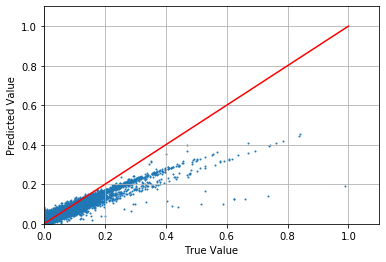

In [18]:
final_sgd = model_and_analyze_in_parallel(SGDRegressor(random_state=42), X_traintest, y_traintest)

Mean squared error 0.00005
Explained variance score 0.98821


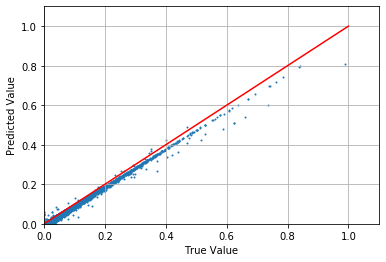

In [19]:
final_ridge = model_and_analyze_in_parallel(Ridge(), X_traintest, y_traintest)